# Определение стоимости автомобилей

Цели работы:
* для сервиса по продаже поддержанных автомобилей построить модели которые могут определить рыночную автомобиля.В распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:

* качество предсказания (метрика RMSE, должно быть меньше 2500)
* время обучения модели;
* время предсказания модели.

Этапы:
* изучить данные
* заполнить пропущенные значения и обработать аномалии в столбцах
* удалить неинформативные признаки
* Подготовить выборки для обучения моделей
* обучить разные модели (согласно тз, одна из них LightGBM, как минимум одна — не бустинг)
* проанализировать время обучения, время предсказания и качество моделей.
* опираясь на критерии заказчика, выбрать лучшую модель, проверьте её качество на тестовой выборке.
* написать выводы

Описание данных

Признаки

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

### Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import warnings
from tqdm import tqdm
from time import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error as mse

In [2]:
STATE = np.random.RandomState(12345)
RSTATE = 21

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('C:\\Users\\Freo\\Desktop\\projects\\datasets\\p10.csv')

In [5]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [6]:
df.corr(numeric_only = True)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


In [7]:
pd.unique(df['NumberOfPictures'])

array([0], dtype=int64)

полезных значений нет

In [8]:
df = df.drop('NumberOfPictures', axis = 1)

удалим так же PostalCode LastSeen

In [9]:
df = df.drop(['PostalCode', 'LastSeen'], axis = 1)

почтовый индекс в принципе мог бы быть чем то полезен, но посмотрев на него в поиске появляются значения сразу многих стран, если это международная база она неинформативна

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
dtypes: int64(5), object(8)
memory usage: 35.1+ MB


In [11]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
dtype: int64

DateCrawled DateCreated RegistrationMonth тоже можно будет удалить, но сначала с помощью них проверим на ошибки в заполнении;
удалим все обьявления где год регистрации машины позже создания обьявления, а так же если он позже даты сбора таблицы

### RegistrationYear

с форматами дат можно не заморачиваться, сам столбец нам будет не нужен, просто создадим столбец-помошник (из года и месяца) с той же формой записи для возможности сравнения посимвольно и отфильтруем датафрейм

In [12]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

In [13]:
df['date_checker'] = df['RegistrationYear'].astype(str) + '-' + df['RegistrationMonth'].astype(str)

In [14]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,date_checker
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,1993-0
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,2011-5
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,2004-8
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,2001-6
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,2008-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,2005-7
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,2005-1
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,2000-3
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,1996-3


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  date_checker       354369 non-null  object
dtypes: int64(5), object(9)
memory usage: 37.9+ MB


оставляем строки где дата регистрации авто раньше даты парсинга таблицы
оставляем строки где дата регистрации авто раньше даты создания обьявления

In [16]:
df = df[df['date_checker'] < df['DateCrawled']]
df = df[df['date_checker'] < df['DateCreated']]

удалим уже ненужные столбцы, а так же наш столбец-помошник

In [17]:
df = df.drop(['DateCrawled', 'DateCreated', 'RegistrationMonth', 'date_checker'], axis = 1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332992 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             332992 non-null  int64 
 1   VehicleType       316685 non-null  object
 2   RegistrationYear  332992 non-null  int64 
 3   Gearbox           315639 non-null  object
 4   Power             332992 non-null  int64 
 5   Model             316199 non-null  object
 6   Kilometer         332992 non-null  int64 
 7   FuelType          308350 non-null  object
 8   Brand             332992 non-null  object
 9   Repaired          270915 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.9+ MB


верхнюю границу выбросов отфильтровали, посмотрим на низ:

<Axes: >

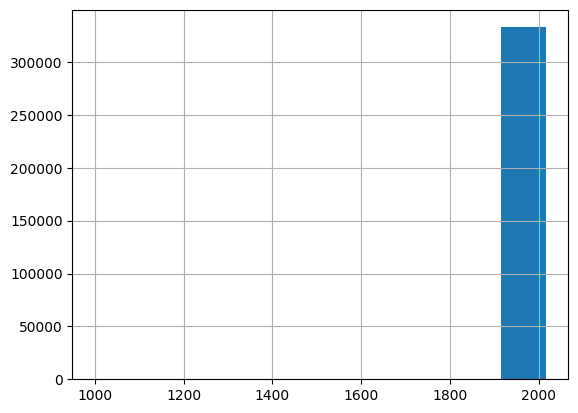

In [19]:
df['RegistrationYear'].hist()

In [20]:
print(sorted(list(df['RegistrationYear'].value_counts().index)))

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


до 1910 года точно удаляем, а начиная с 20 века посмотрим поближе, где заканчивается граница выбросов и начинается граница старинных антикварных экземпляров

In [21]:
df[df['RegistrationYear'] == 1910]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
6629,0,small,1910,NaN,0,NaN,5000,other,sonstige_autos,NaN
6977,135,NaN,1910,NaN,0,NaN,5000,NaN,opel,NaN
10183,1250,NaN,1910,NaN,0,other,5000,NaN,audi,NaN
18023,1,NaN,1910,NaN,0,NaN,5000,NaN,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
331076,0,NaN,1910,NaN,0,NaN,5000,NaN,sonstige_autos,NaN
333004,0,suv,1910,manual,0,NaN,5000,NaN,toyota,NaN
334901,1300,NaN,1910,NaN,0,NaN,5000,NaN,audi,NaN
343083,1,other,1910,NaN,0,NaN,5000,other,volkswagen,NaN


похожи на ошибочное заполнение

In [22]:
df[df['RegistrationYear'] == 1915]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
270235,0,sedan,1915,NaN,0,NaN,125000,NaN,sonstige_autos,NaN


In [23]:
df[df['RegistrationYear'] == 1919]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
197739,0,other,1919,manual,0,other,150000,petrol,ford,yes


In [24]:
df[(df['RegistrationYear'] > 1910)&(df['RegistrationYear'] < 1945)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2273,1800,convertible,1925,NaN,0,NaN,5000,NaN,sonstige_autos,no
16635,9500,suv,1941,manual,57,NaN,40000,petrol,sonstige_autos,no
22621,14000,sedan,1929,manual,30,NaN,5000,petrol,sonstige_autos,NaN
26216,15000,small,1940,manual,24,NaN,5000,petrol,sonstige_autos,no
29933,12900,sedan,1940,manual,0,NaN,150000,petrol,ford,NaN
...,...,...,...,...,...,...,...,...,...,...
335758,17000,convertible,1944,manual,30,NaN,5000,petrol,sonstige_autos,no
336104,20000,coupe,1929,manual,12,other,10000,petrol,bmw,NaN
338109,7000,coupe,1937,manual,85,other,5000,petrol,ford,yes
346046,18900,suv,1943,manual,60,other,150000,petrol,volkswagen,no


машин мало, много кабриолетов не типичных машин, границу вполне можно провести с 1910 года
в принципе если целевой аудиторией сервиса является "обычный" автовладелец границу можно взять и правее, тогда точность "обычных" прогнозов повысится, но качество обработки "нетипичных" будет ужасным. Пока оставим так, до уточнения тз у заказчика

In [25]:
df = df[df['RegistrationYear'] > 1911]

In [26]:
print(sorted(list(df['RegistrationYear'].value_counts().index)))

[1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


In [27]:
df['RegistrationYear'].value_counts()

RegistrationYear
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
1915        1
1920        1
1949        1
1927        1
1946        1
Name: count, Length: 94, dtype: int64

<Axes: >

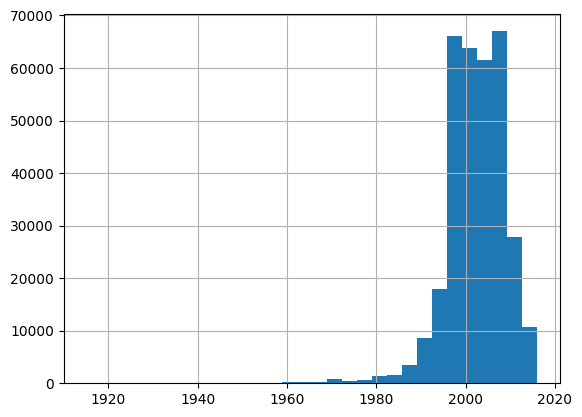

In [28]:
df['RegistrationYear'].hist(bins=30)

### Model

In [29]:
df['Model'].value_counts()

Model
golf                  26871
other                 23542
3er                   18993
polo                  12108
corsa                 11588
                      ...  
kalina                    6
serie_3                   4
rangerover                3
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

In [30]:
print(sorted(list(df['Model'].value_counts().index)))

['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fox', 'freelander', 'fusion', 

модель врятли получится заполнить чем нибудь вменяемым, это важный параметр от которого очень сильно зависит целевой признак, заполнив чем попало мы испортим данные; обьединив все машины с пропусками в название "другие" - испортим данные (машины внутри него будут очень сильно отличаться друг от друга)

In [31]:
df['Model'].isna().sum() /df.shape[0] 

0.05016750544580485

к счастью таких данные всего 5%, удалим их

In [32]:
df = df.dropna(subset=['Model'])
df = df.reset_index(drop=True)

### Brand

In [33]:
df['Brand'].value_counts()

Brand
volkswagen       68540
opel             35403
bmw              33768
mercedes_benz    29518
audi             26969
ford             22738
renault          15842
peugeot           9680
fiat              8524
seat              6175
skoda             5170
mazda             4987
smart             4727
citroen           4615
nissan            4474
toyota            4257
hyundai           3228
mini              3021
volvo             3008
mitsubishi        2704
honda             2496
kia               2227
alfa_romeo        2079
suzuki            2076
chevrolet         1587
chrysler          1295
dacia              845
daihatsu           725
porsche            703
subaru             690
jeep               625
land_rover         524
saab               494
jaguar             486
trabant            485
daewoo             456
lancia             414
rover              376
lada               197
Name: count, dtype: int64

пропусков нет, повторов нет, тут все ок

### power

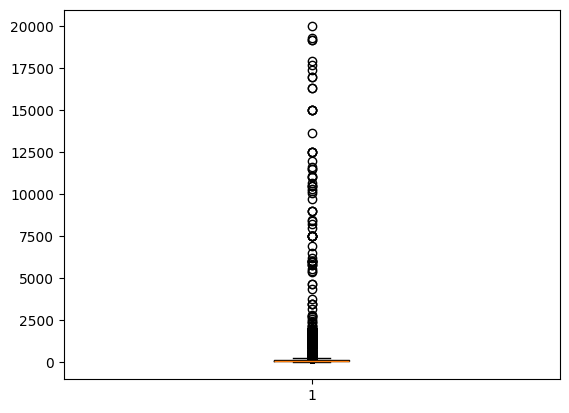

In [34]:
plt.boxplot(df['Power']);

<Axes: >

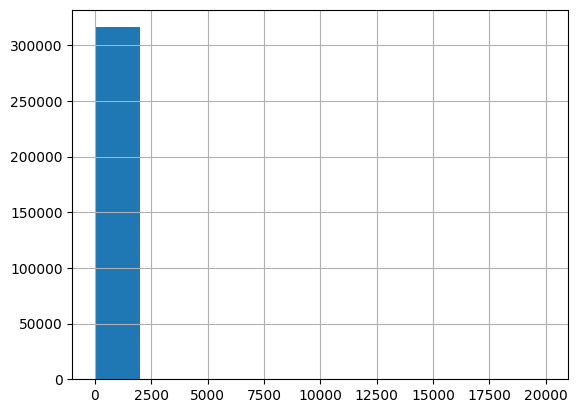

In [35]:
df['Power'].hist()

 воспользуемся поиском и посмотрим какой верхний предел адекватной границы лс для авто;

до 600 - могут быть вполне реальные значения, хоть и весьма нетипичные

посмотрим на них поближе

In [36]:
df[df['Power']>500]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1609,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
1863,0,sedan,1999,NaN,1799,vectra,150000,petrol,opel,yes
3616,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
4729,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
5593,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
...,...,...,...,...,...,...,...,...,...,...
311193,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,NaN
311270,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
313933,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
315456,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN


In [37]:
df[(df['Power']>570)&(df['Power']<700)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
5593,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
5891,600,small,1996,manual,603,corsa,150000,petrol,opel,yes
7159,500,small,2002,manual,620,ypsilon,150000,petrol,lancia,NaN
11899,18500,small,2002,auto,600,s_type,150000,NaN,jaguar,no
20664,400,NaN,2015,auto,610,other,5000,NaN,audi,NaN
37905,450,small,1999,manual,601,arosa,150000,NaN,seat,no
38876,12999,wagon,2004,auto,600,a6,150000,petrol,audi,NaN
74158,1700,small,2006,manual,671,matiz,100000,petrol,chevrolet,NaN
91631,19500,coupe,1974,auto,600,other,5000,petrol,chevrolet,no
94342,19000,wagon,2008,auto,579,other,150000,petrol,audi,yes


часть машин выглядит реалистично, высокая цена, известные дорогие модели

посмотрим как много машин находится ниже интуитивно нереалистичной границы

In [38]:
df[df['Price']<100]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
6,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
33,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
74,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
133,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
135,0,NaN,2006,NaN,0,other,5000,NaN,fiat,NaN
...,...,...,...,...,...,...,...,...,...,...
316005,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
316014,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
316042,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
316073,99,small,1999,manual,60,arosa,150000,petrol,seat,yes


машин много, полно нулей в цене это обработаем чуть позже; изменим аномальные значения мощности двигателя:

алгоритм изменения:
* для каждой модели возьмем значения не являющиеся явной аномалией (в диапазоне от 25 до 600 лс) и посчитаем для каждой модели медианное значение мощности
* для каждой строки с аномальным значением мощности ( <25; >600) заменим его на медианное этой модели

In [39]:
for mdl in df['Model'].unique():
    if mdl != 'other':
        median_model_pwr = df.loc[(df['Model'] == mdl) & (df['Power'] < 600) & (df['Power'] > 25), 'Power'].median()
        df.loc[(df['Model'] == mdl) & (df['Power'] <= 25), 'Power'] = median_model_pwr
        df.loc[(df['Model'] == mdl) & (df['Power'] >= 600), 'Power'] = median_model_pwr

у нас так же остались много машин в категории "другие" найдем нижнюю границу выбросов;

In [40]:
df[df['Power'] < 25]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
135,0,NaN,2006,NaN,0.0,other,5000,NaN,fiat,NaN
140,300,small,1994,manual,0.0,other,150000,petrol,mitsubishi,NaN
154,300,bus,1997,manual,0.0,other,150000,petrol,opel,NaN
214,10200,coupe,2008,manual,0.0,other,90000,petrol,nissan,NaN
298,3550,sedan,1993,manual,0.0,other,125000,petrol,chevrolet,NaN
...,...,...,...,...,...,...,...,...,...,...
315706,800,NaN,1970,NaN,0.0,other,150000,NaN,trabant,NaN
315721,750,small,2001,NaN,0.0,other,150000,petrol,hyundai,NaN
315905,2300,bus,2000,manual,0.0,other,80000,gasoline,citroen,no
315984,790,NaN,1990,manual,0.0,other,150000,petrol,renault,NaN


In [41]:
df[(df['Power'] > 2) & (df['Power'] < 25)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
11182,5999,small,2014,auto,15.0,other,10000,electric,renault,no
11770,5799,small,2013,auto,18.0,other,10000,electric,renault,no
17033,1500,small,1960,manual,21.0,other,5000,petrol,renault,yes
20254,200,coupe,2001,manual,14.0,other,5000,petrol,toyota,yes
21326,3333,small,1975,manual,23.0,other,40000,petrol,fiat,no
...,...,...,...,...,...,...,...,...,...,...
297289,16500,convertible,1969,manual,18.0,other,90000,petrol,fiat,no
299842,20000,coupe,1929,manual,12.0,other,10000,petrol,bmw,NaN
306241,5250,small,2012,auto,11.0,other,50000,electric,renault,no
307713,6500,small,2012,auto,13.0,other,20000,electric,renault,no


подавляющее большинство значений которые меньше 25 лс лежат в диапазоне от 0 до 2 и точно являются выбросами, посмотрим поближе где можно провести границу

In [42]:
df[(df['Power'] > 2) & (df['Power'] < 20)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
11182,5999,small,2014,auto,15.0,other,10000,electric,renault,no
11770,5799,small,2013,auto,18.0,other,10000,electric,renault,no
20254,200,coupe,2001,manual,14.0,other,5000,petrol,toyota,yes
25821,5299,small,2012,auto,11.0,other,30000,electric,renault,no
30265,4999,small,2012,auto,5.0,other,5000,electric,renault,no
30467,1250,small,1993,manual,17.0,other,60000,petrol,fiat,yes
30611,655,NaN,1995,manual,5.0,other,70000,NaN,seat,NaN
33596,1300,wagon,1999,auto,9.0,other,30000,petrol,citroen,no
36857,3500,small,1976,manual,13.0,other,30000,petrol,fiat,NaN
38302,4200,other,2012,auto,8.0,other,40000,electric,renault,no


In [43]:
df[(df['Power'] > 2) & (df['Power'] < 15)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
20254,200,coupe,2001,manual,14.0,other,5000,petrol,toyota,yes
25821,5299,small,2012,auto,11.0,other,30000,electric,renault,no
30265,4999,small,2012,auto,5.0,other,5000,electric,renault,no
30611,655,NaN,1995,manual,5.0,other,70000,NaN,seat,NaN
33596,1300,wagon,1999,auto,9.0,other,30000,petrol,citroen,no
36857,3500,small,1976,manual,13.0,other,30000,petrol,fiat,NaN
38302,4200,other,2012,auto,8.0,other,40000,electric,renault,no
49243,6690,other,1959,manual,12.0,other,50000,petrol,bmw,no
50824,4499,small,2012,auto,11.0,other,30000,electric,renault,no
56804,4899,small,2012,auto,11.0,other,20000,electric,renault,no


In [44]:
df[(df['Power'] > 2) & (df['Power'] < 10)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
30265,4999,small,2012,auto,5.0,other,5000,electric,renault,no
30611,655,NaN,1995,manual,5.0,other,70000,NaN,seat,NaN
33596,1300,wagon,1999,auto,9.0,other,30000,petrol,citroen,no
38302,4200,other,2012,auto,8.0,other,40000,electric,renault,no
123576,5200,NaN,1980,manual,9.0,other,150000,NaN,opel,NaN
283439,1500,small,1994,manual,5.0,other,70000,petrol,seat,NaN


ниже 5 лс машин уже нет; тут и проведем границу

In [45]:
df = df[(df['Power'] < 600) & (df['Power'] >= 5)]

In [46]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,101.0,golf,150000,petrol,volkswagen,NaN
1,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,NaN
2,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
316123,1150,bus,2000,manual,125.0,zafira,150000,petrol,opel,no
316124,0,NaN,2005,manual,82.0,colt,150000,petrol,mitsubishi,yes
316125,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
316126,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


посмотрим итоговое распределение лс

<Axes: >

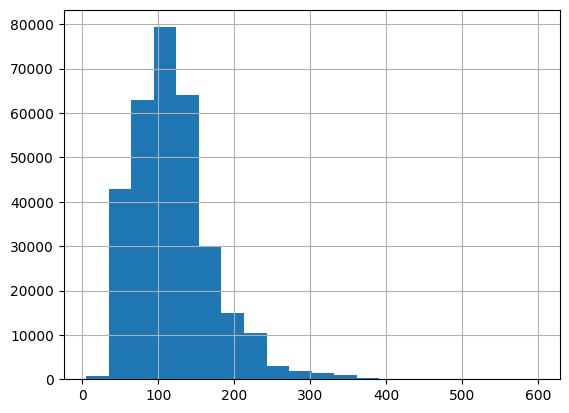

In [47]:
df['Power'].hist(bins=20)

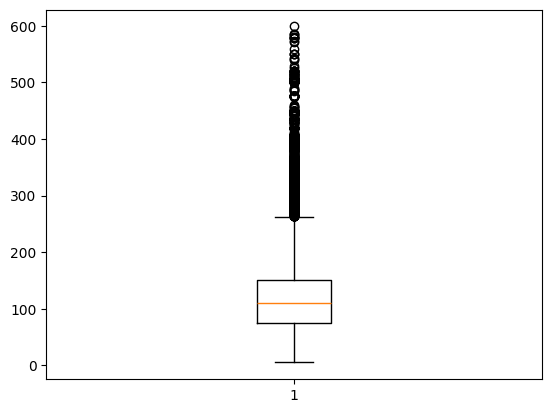

In [48]:
plt.boxplot(df['Power']);

In [49]:
df[(df['Power']<600) & (df['Power']>=300)].describe()

,Price,RegistrationYear,Power,Kilometer
count,2983.000000,2983.000000,2983.000000,2983.000000
mean,11569.199128,2002.719075,342.231646,134378.142809
std,5292.166864,6.205474,49.728751,33073.711220
min,0.000000,1950.000000,300.000000,5000.000000
25%,7900.000000,2001.000000,306.000000,125000.000000
50%,11900.000000,2004.000000,330.000000,150000.000000
75%,15900.000000,2006.000000,349.000000,150000.000000
max,20000.000000,2016.000000,599.000000,150000.000000


выглядит правдоподобно

проверим "мощные" машины; туда могли затесаться авто из модели 'other' которые было нельзя обьединить и оценить

<Axes: >

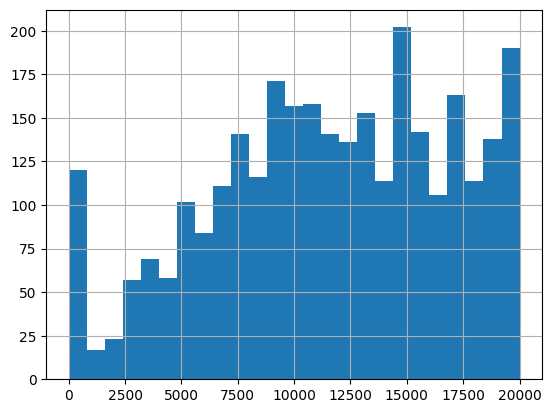

In [50]:
df[(df['Power']<600) & (df['Power']>=300)]['Price'].hist(bins=25)

так и есть, среди мощных машин есть выброс в крайне низкой цене

<Axes: >

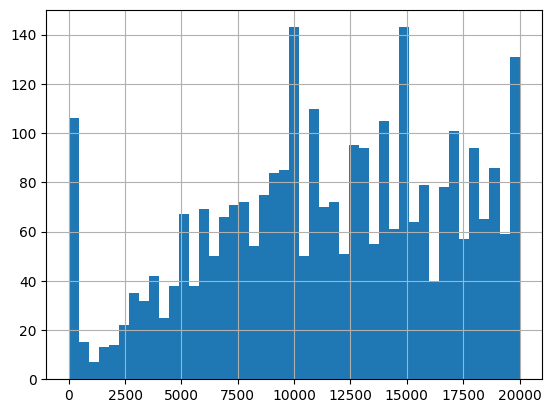

In [51]:
df[(df['Power']<600) & (df['Power']>=300)]['Price'].hist(bins=45)

удалим из таблицы машины которые имеют под капотом от 300 до 600 лс и стоят меньше 1500 (границу взяли из графика примерно по нижней части левого хвоста нормального распределения)

In [52]:
df = df[~((df['Power']<600) & (df['Power']>=300) & (df['Price'] < 1500))]

In [53]:
df.isna().sum()

Price                   0
VehicleType         11616
RegistrationYear        0
Gearbox             12720
Power                   0
Model                   0
Kilometer               0
FuelType            18078
Brand                   0
Repaired            52874
dtype: int64

### Price

продолжим смотреть цену

у нас осталась большая часть машин модели "другие" аномально низкой ценой

<Axes: >

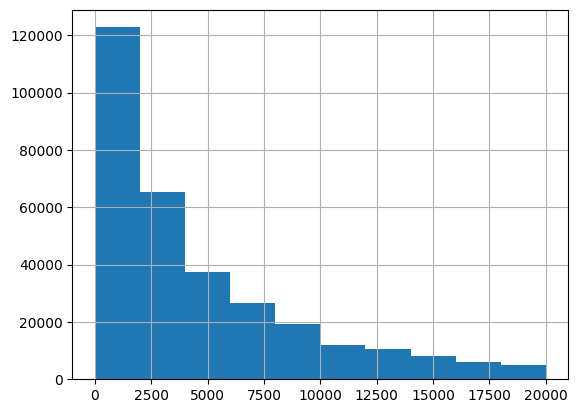

In [54]:
df['Price'].hist()

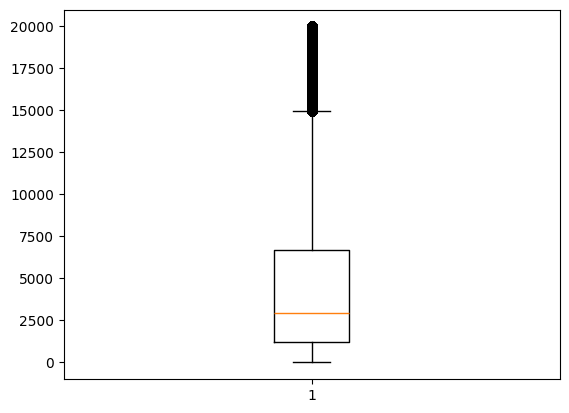

In [55]:
plt.boxplot(df['Price']);

In [56]:
df[df['Price'] < 1000]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,101.0,golf,150000,petrol,volkswagen,NaN
4,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes
6,0,sedan,1980,manual,50.0,other,40000,petrol,volkswagen,no
8,999,small,1998,manual,101.0,golf,150000,NaN,volkswagen,NaN
11,999,wagon,1995,manual,115.0,passat,150000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
316103,699,sedan,1999,manual,101.0,vectra,150000,petrol,opel,NaN
316104,600,small,1998,manual,54.0,corsa,150000,petrol,opel,no
316109,800,wagon,2000,manual,101.0,astra,150000,petrol,opel,yes
316117,999,convertible,2000,manual,95.0,megane,150000,petrol,renault,NaN


построим график

<Axes: >

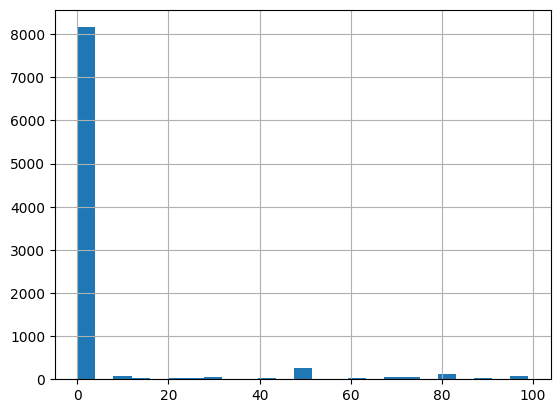

In [57]:
df[df['Price'] < 100]['Price'].hist(bins=25)

удалим аномалии; границей поставим 20 евро (хотя можно и выше; но в принцпе количество машин там итак не большое; главное удалить околонулевой мусор)

In [58]:
df = df[~(df['Price'] < 20)]

In [59]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,101.0,golf,150000,petrol,volkswagen,NaN
1,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,NaN
2,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
316122,3200,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
316123,1150,bus,2000,manual,125.0,zafira,150000,petrol,opel,no
316125,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
316126,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


<Axes: >

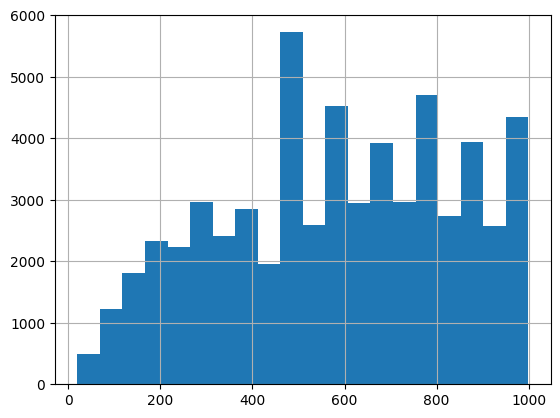

In [60]:
df[df['Price'] < 1000]['Price'].hist(bins=20)

выглядит неплохо

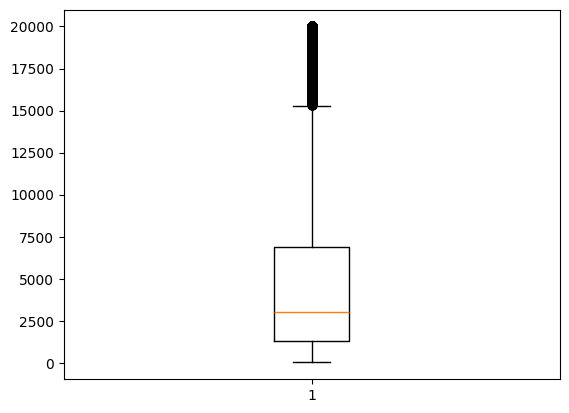

In [61]:
plt.boxplot(df['Price']);

с учетом нашего тз мне показалось что будет уместным дополнительно внести правки в границы цен; для каждой из моделей машин(кроме "другое") ограничить верхие и нижние границы; средние цифры в данном случае куда точнее определяют задачу чем выбросы в виде экземляров с неадедекватно высокой или неадекватно низкой ценой;


посчитаем среднюю цену внутри каждой модели; все что в 8 раз выше и ниже средней цены - заполним ей.

подобное заполнение по цене былобы неприемлимо, а в рамках каждой из моделей машин - думаю криминальным не будет

(если заполнять по границе оклонения в 3 сигмы мы часто не захватим большУю неадекватных цен)

In [62]:
for mdl in df['Model'].unique():
    if mdl != 'other':
        #print(mdl)
        mdl_mean = df[df['Model'] == mdl]['Price'].describe()[1]
        df.loc[(df['Price'] > (mdl_mean * 8)) & (df['Model']  == mdl), 'Price'] = mdl_mean
        df.loc[(df['Price'] < (mdl_mean / 8)) & (df['Model']  == mdl), 'Price'] = mdl_mean

In [63]:
df[df['Model']=='other']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
21,500.0,sedan,1990,manual,118.0,other,150000,petrol,mercedes_benz,yes
31,11900.0,other,2002,manual,129.0,other,150000,gasoline,volkswagen,no
32,1500.0,bus,1984,manual,70.0,other,150000,gasoline,mercedes_benz,no
54,2100.0,suv,2000,manual,105.0,other,150000,petrol,honda,no
55,1280.0,sedan,1992,auto,109.0,other,150000,petrol,mercedes_benz,NaN
...,...,...,...,...,...,...,...,...,...,...
316051,16500.0,coupe,1973,manual,200.0,other,150000,petrol,bmw,yes
316054,2500.0,small,2007,manual,60.0,other,125000,petrol,hyundai,NaN
316080,3300.0,coupe,1957,manual,40.0,other,100000,petrol,trabant,no
316088,12800.0,convertible,1991,manual,211.0,other,150000,petrol,porsche,no


In [64]:
df.isna().sum()

Price                   0
VehicleType          9845
RegistrationYear        0
Gearbox             11309
Power                   0
Model                   0
Kilometer               0
FuelType            16134
Brand                   0
Repaired            49213
dtype: int64

### Kilometer

<Axes: >

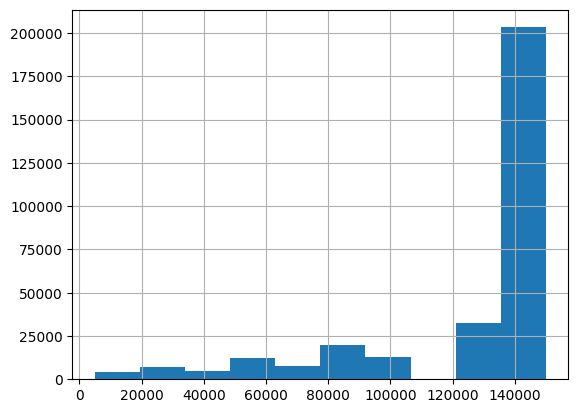

In [65]:
df['Kilometer'].hist()

In [66]:
df[df['Repaired'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,4410.984467,NaN,1993,manual,101.0,golf,150000,petrol,volkswagen,NaN
1,9800.000000,suv,2004,auto,163.0,grand,125000,gasoline,jeep,NaN
7,14500.000000,bus,2014,manual,125.0,c_max,30000,petrol,ford,NaN
8,999.000000,small,1998,manual,101.0,golf,150000,NaN,volkswagen,NaN
11,999.000000,wagon,1995,manual,115.0,passat,150000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
316108,2600.000000,NaN,2005,auto,143.0,c_klasse,150000,NaN,mercedes_benz,NaN
316111,5999.000000,wagon,2005,manual,140.0,a4,150000,gasoline,audi,NaN
316117,999.000000,convertible,2000,manual,95.0,megane,150000,petrol,renault,NaN
316118,1690.000000,wagon,2004,manual,55.0,fabia,150000,petrol,skoda,NaN


проверим, может не заполненная графа починки подразумеваем что машина новая и без пробега?

<Axes: >

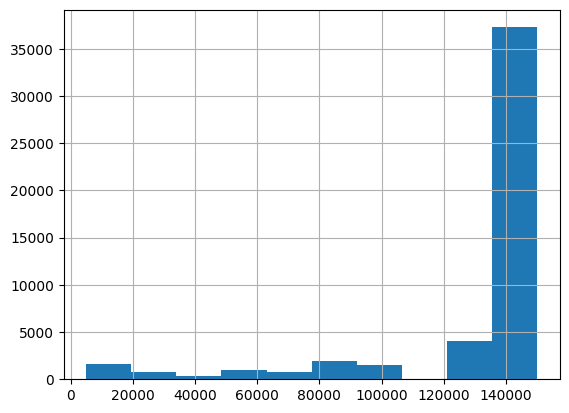

In [67]:
df[df['Repaired'].isna()]['Kilometer'].hist()

<Axes: >

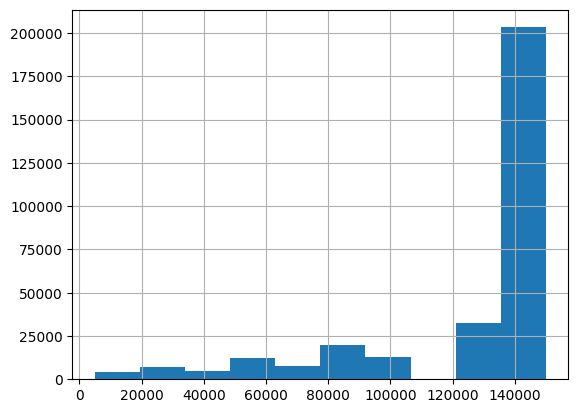

In [68]:
df['Kilometer'].hist()

пропусков нет, значения выглядят адекватно

### Repaired

скорее всего эту категорию как и категорию модели не получится заполнить не испортив данные, лучше удалим или заполним "неизвестно"

In [69]:
df['Repaired'] = df['Repaired'].fillna('unknown')

In [70]:
df.isna().sum()

Price                   0
VehicleType          9845
RegistrationYear        0
Gearbox             11309
Power                   0
Model                   0
Kilometer               0
FuelType            16134
Brand                   0
Repaired                0
dtype: int64

### VehicleType Gearbox FuelType

In [71]:
df['VehicleType'].value_counts()

VehicleType
sedan          85614
small          74261
wagon          61338
bus            26983
convertible    18881
coupe          14520
suv            10852
other           2495
Name: count, dtype: int64

In [72]:
df['Gearbox'].value_counts()

Gearbox
manual    234411
auto       59069
Name: count, dtype: int64

In [73]:
df['FuelType'].value_counts()

FuelType
petrol      192255
gasoline     90951
lpg           4608
cng            501
hybrid         182
other          100
electric        58
Name: count, dtype: int64

насчет следующих 3х категорий есть несколько вариантов:
* удалить данные
* заполнить с помощью мл
* заполнить внутри каждой марки машины пропорционально распределению вероятностей

попробуем сначала третий вариант;

алгоритм заполнения:
* для каждой модели машин в имеющихся данных посчитаем распределение имеющихся критериев: (для каждой модели распределение количества коробок передач авто\ручник; видов топлива и типа машины)
* создать список списков с моделью машины и парами словарей (критерий-его вероятность; для этого можно посчтать отношение каждого признака к общему количество признаков; а зачем "расположить" их в диапазоне от нуля до единицы, начиная от наиболее верноятных, прибавляя вероятность следующего к верхней границы прошлой
* создать в датафрейме дополнительную колонку случайных значений в диапазоне от нуля до 1 с точностью в несколько знаков после запятой
* с заполним пропущенные значения с помощью фильтра ( проходим по всему списку моделей, и для тех строк этой модели где пропущено значение, сравниваем наше случайное число с границей вероятности; таким образом пропуски будут заполнены пропорционально распределению имеющихся значений для каждой из модели)


конечно подобным заполнением мы слегка уменьшим предсказательную силу конкретно этих критериев, но они в данном случае они не очень важные, и заполнив их таким образом мы сохраним другие более интересные.


In [74]:
list_of_v_type = []
list_of_fuel = []
list_of_gear = []
list_of_lists = [list_of_v_type, list_of_fuel, list_of_gear]
list_of_columns = ['VehicleType', 'FuelType', 'Gearbox' ]

In [75]:
for j in tqdm(range(len(list_of_lists))):
    for mdl in df['Model'].unique():
        if mdl != 'other':

            list_for_each = []
            list_for_each.append(mdl)

            sum_total = df[df['Model']==mdl][list_of_columns[j]].value_counts().sum()
            len_total = len(df[df['Model']==mdl][list_of_columns[j]].value_counts())
            _var = df[df['Model']==mdl][list_of_columns[j]].value_counts()


            current = 0
            for i in range(len_total):
                current += _var[i] / sum_total
                list_for_each.append({_var.index[i] : current})
            list_of_lists[j].append(list_for_each)


100%|██████████| 3/3 [00:39<00:00, 13.18s/it]


In [76]:
list_of_gear

[['golf', {'manual': 0.8902782245094886}, {'auto': 1.0}],
 ['grand', {'auto': 0.615819209039548}, {'manual': 1.0}],
 ['fabia', {'manual': 0.950591868244982}, {'auto': 1.0}],
 ['3er', {'manual': 0.8010629370629371}, {'auto': 1.0}],
 ['2_reihe', {'manual': 0.9673864147548358}, {'auto': 1.0}],
 ['c_max', {'manual': 0.9253246753246753}, {'auto': 1.0}],
 ['3_reihe', {'manual': 0.9329929802169751}, {'auto': 1.0}],
 ['passat', {'manual': 0.7677782685512368}, {'auto': 1.0}],
 ['navara', {'manual': 0.813953488372093}, {'auto': 1.0}],
 ['polo', {'manual': 0.9603978138159663}, {'auto': 1.0}],
 ['twingo', {'manual': 0.9563511525257479}, {'auto': 1.0}],
 ['a_klasse', {'manual': 0.7498572244431754}, {'auto': 1.0}],
 ['scirocco', {'manual': 0.8191681735985533}, {'auto': 1.0}],
 ['5er', {'auto': 0.5592663564193814}, {'manual': 1.0}],
 ['arosa', {'manual': 0.970013037809648}, {'auto': 1.0}],
 ['civic', {'manual': 0.9397379912663756}, {'auto': 1.0}],
 ['transporter', {'manual': 0.9055581723975507}, {'au

создадим колонку со случайными значениями

In [77]:
df['randomized_column'] = STATE.randint(0, 1000001, df.shape[0])

In [78]:
df['randomized_column'] = df['randomized_column'] / 1000000

заполним пропуски по фильтру

In [79]:
#df

In [80]:
for i in tqdm(range(len(list_of_gear))):
    for j in range(1,len(list_of_gear[i])):
        df.loc[(df['Model'] == list_of_gear[i][0]) & (df['Gearbox'].isna()) & 
               (df['randomized_column'] <= list(list_of_gear[i][j].values())[0]), 'Gearbox'] = list(list_of_gear[i][j].keys())[0]

100%|██████████| 248/248 [00:13<00:00, 17.77it/s]


In [81]:
for i in tqdm(range(len(list_of_v_type))):
    for j in range(1,len(list_of_v_type[i])):
        df.loc[(df['Model'] == list_of_v_type[i][0]) & (df['VehicleType'].isna()) & 
               (df['randomized_column'] <= list(list_of_v_type[i][j].values())[0]), 'VehicleType'] = list(list_of_v_type[i][j].keys())[0]

100%|██████████| 248/248 [00:31<00:00,  7.82it/s]


In [82]:
for i in tqdm(range(len(list_of_fuel))):
    for j in range(1,len(list_of_fuel[i])):
        df.loc[(df['Model'] == list_of_fuel[i][0]) & (df['FuelType'].isna()) & 
               (df['randomized_column'] <= list(list_of_fuel[i][j].values())[0]), 'FuelType'] = list(list_of_fuel[i][j].keys())[0]

100%|██████████| 248/248 [00:22<00:00, 11.14it/s]


In [83]:
df.isna().sum()

Price                  0
VehicleType          300
RegistrationYear       0
Gearbox              302
Power                  0
Model                  0
Kilometer              0
FuelType             676
Brand                  0
Repaired               0
randomized_column      0
dtype: int64

остались пропуски соответсвующие модели "other" которые могут очень сильно отличаться друг от друга, удалим оставшиеся пропуски

In [84]:
df = df.dropna(axis=0)

In [85]:
df = df.reset_index(drop=True)

In [86]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,randomized_column
0,4410.984467,wagon,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown,0.741858
1,9800.000000,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,0.077285
2,1500.000000,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,0.916765
3,3600.000000,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,0.395393
4,5240.821687,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,0.347556
...,...,...,...,...,...,...,...,...,...,...,...
303734,3200.000000,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes,0.393074
303735,1150.000000,bus,2000,manual,125.0,zafira,150000,petrol,opel,no,0.769141
303736,1199.000000,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no,0.174232
303737,9200.000000,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no,0.950916


удалим столбец-рандомизатор

In [87]:
df = df.drop('randomized_column', axis = 1)

In [88]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,4410.984467,wagon,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown
1,9800.000000,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
2,1500.000000,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
3,3600.000000,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
4,5240.821687,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
303734,3200.000000,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
303735,1150.000000,bus,2000,manual,125.0,zafira,150000,petrol,opel,no
303736,1199.000000,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
303737,9200.000000,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


In [89]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [90]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,4410.984467,wagon,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown
1,9800.000000,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
2,1500.000000,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
3,3600.000000,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
4,5240.821687,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
303734,3200.000000,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
303735,1150.000000,bus,2000,manual,125.0,zafira,150000,petrol,opel,no
303736,1199.000000,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
303737,9200.000000,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


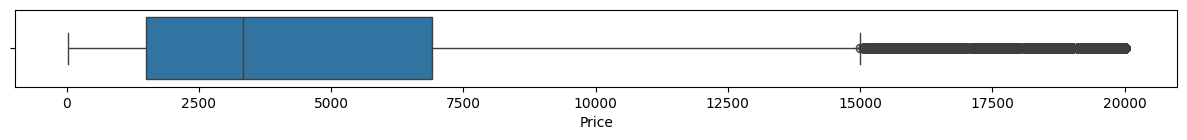

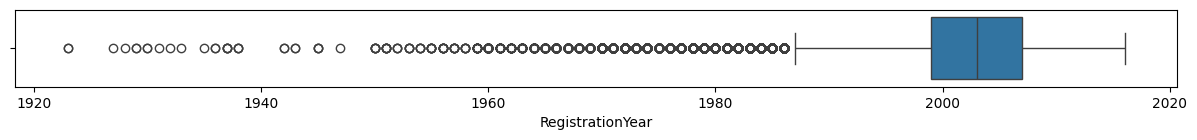

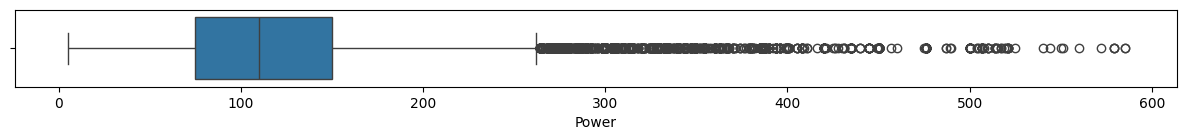

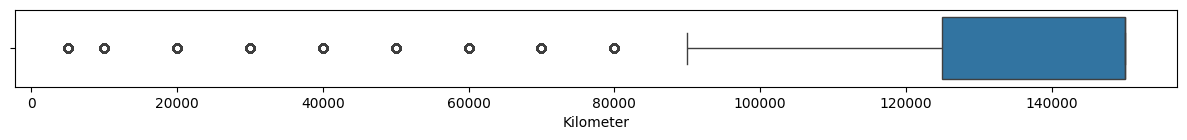

In [91]:
for el in ['Price','RegistrationYear','Power','Kilometer']:
    plt.figure(figsize=(15,1))
    sns.boxplot(data=df[el],orient='h');
    plt.show()

EDA
- [x]  Price
- [x]  VehicleType
- [x]  RegistrationYear
- [x]  Gearbox
- [x]  Power
- [x]  Model
- [x]  Kilometer
- [x]  FuelType
- [x]  Brand
- [x]  Repaired

### подготовка к МЛ

создадим признаки для моделей машинного обучения

In [92]:
x = df.drop('Price', axis = 1)

In [93]:
y = df['Price']

In [94]:
x

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,wagon,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown
1,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
2,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
3,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
4,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
303734,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
303735,bus,2000,manual,125.0,zafira,150000,petrol,opel,no
303736,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
303737,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


In [95]:
y

0         4410.984467
1         9800.000000
2         1500.000000
3         3600.000000
4         5240.821687
             ...     
303734    3200.000000
303735    1150.000000
303736    1199.000000
303737    9200.000000
303738    3400.000000
Name: Price, Length: 303739, dtype: float64

разделим на трейн валид и тест

In [96]:
x_temp, x_test, y_temp, y_test = train_test_split(x,y, test_size=0.2, random_state=RSTATE)

In [97]:
x_train, x_valid, y_train, y_valid = train_test_split(x_temp,y_temp, test_size=0.5, random_state=RSTATE)

In [98]:
x_list = [x_train, x_valid, x_test]
y_list = [y_train, y_valid, y_test]

создадим для удобства списки категориальных и числовых

In [99]:
cat_list = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']
numeric_list = ['RegistrationYear', 'Power', 'Kilometer']

скалируем числовые признаки

In [100]:
scaler = StandardScaler()

In [101]:
scaler.fit(x_train[numeric_list])
for el in x_list:
    el[numeric_list] = scaler.transform(el[numeric_list])

In [102]:
x_train

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
8953,coupe,-0.098724,manual,2.126739,3er,0.583930,petrol,bmw,no
186043,sedan,0.062703,manual,0.522648,vectra,0.583930,petrol,opel,no
174188,bus,-0.744431,auto,-0.871384,transporter,0.583930,gasoline,volkswagen,yes
253938,wagon,0.708409,manual,1.477464,3er,0.583930,gasoline,bmw,no
223627,small,-0.421577,manual,-1.176925,twingo,0.583930,petrol,renault,no
...,...,...,...,...,...,...,...,...,...
298105,small,-0.098724,manual,-0.126627,cooper,0.583930,petrol,mini,no
161067,small,-0.098724,manual,-1.138733,micra,0.583930,petrol,nissan,no
208278,sedan,0.708409,manual,0.579937,3er,-0.095500,petrol,bmw,unknown
229127,sedan,0.869836,manual,0.388973,golf,-0.774929,petrol,volkswagen,no


изменим тип категориальных переменных для лайтГБМ

In [103]:
for el in x_list:
    for cat in cat_list:
        el[cat] = el[cat].astype('category')

### Итог этапа

в ходе работы мы:
* изучили данные
* заполнили пропущенные значения и обработали аномалии в столбцах
* удалили неинформативные признаки (дата скачивания анкеты из базы, дата создания анкеты, почтовый индекс владельца анкеты, дата последней активности, месяц регистрации автомобиля)
* Подготовить выборки для обучения моделей

## Обучение моделей

создадим таблицу для итоговых результатов

In [104]:
result_table = []

### LightGBM

In [105]:
for i in range (2,13):
    model = LGBMRegressor(max_depth=i, learning_rate=0.5 )
    model.fit(x_train,y_train)
    pred_valid = model.predict(x_valid)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print('dpt', i)
    print(rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 121495, number of used features: 9
[LightGBM] [Info] Start training from score 4907.534993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
dpt 2
1777.0473107042237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 121495, number of used features: 9
[LightGBM] [Info] Start training from score 4907.534993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [106]:
for i in range(5, 51, 5):
    model = LGBMRegressor(max_depth=10, learning_rate=(i * 0.01) )
    model.fit(x_train,y_train)
    pred_valid = model.predict(x_valid)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print('lr', (i * 0.01))
    print(rmse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 121495, number of used features: 9
[LightGBM] [Info] Start training from score 4907.534993
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
lr 0.05
1689.1058007802155
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad sinc

In [107]:
row_for_result = []

In [108]:
row_for_result.append('lightGBM')

In [109]:
model = LGBMRegressor(max_depth=10, learning_rate=0.26 )

In [110]:
%%time
model.fit(x_train,y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 121495, number of used features: 9
[LightGBM] [Info] Start training from score 4907.534993
CPU times: total: 2.36 s
Wall time: 302 ms


LGBMRegressor(learning_rate=0.26, max_depth=10)

In [111]:
row_for_result.append(2.61)

In [112]:
%%time
pred_valid = model.predict(x_valid)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 1.09 s
Wall time: 132 ms


In [113]:
row_for_result.append(0.823)

In [114]:
rmse = mse(y_valid,pred_valid) ** 0.5
row_for_result.append(rmse)
print(rmse)

1632.7970808882499


In [115]:
result_table.append(row_for_result)

### 😼-boost

In [116]:
for i in range (2,15):
    model = CatBoostRegressor(loss_function="RMSE", iterations=200, depth=i)
    model.fit(x_train,y_train, cat_features=cat_list, verbose=25)
    pred_valid = model.predict(x_valid)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

Learning rate set to 0.323446
0:	learn: 3792.7450311	total: 160ms	remaining: 31.8s
25:	learn: 2065.6146005	total: 670ms	remaining: 4.48s
50:	learn: 1943.4204863	total: 1.15s	remaining: 3.35s
75:	learn: 1890.9876398	total: 1.69s	remaining: 2.76s
100:	learn: 1859.1878516	total: 2.17s	remaining: 2.13s
125:	learn: 1836.2610593	total: 2.63s	remaining: 1.54s
150:	learn: 1821.8041792	total: 3.1s	remaining: 1.01s
175:	learn: 1807.0218713	total: 3.56s	remaining: 486ms
199:	learn: 1798.2294183	total: 3.98s	remaining: 0us
2
1814.9074253439821
Learning rate set to 0.323446
0:	learn: 3707.3757730	total: 28.9ms	remaining: 5.74s
25:	learn: 1952.9757807	total: 782ms	remaining: 5.23s
50:	learn: 1851.4312079	total: 1.48s	remaining: 4.32s
75:	learn: 1806.6205571	total: 2.2s	remaining: 3.6s
100:	learn: 1781.4477294	total: 2.93s	remaining: 2.87s
125:	learn: 1763.4422469	total: 3.66s	remaining: 2.15s
150:	learn: 1750.3334193	total: 4.38s	remaining: 1.42s
175:	learn: 1738.0342169	total: 5.17s	remaining: 704m

In [117]:
for i in range (100,501,50):
    model = CatBoostRegressor(loss_function="RMSE", iterations=i, depth=12)
    model.fit(x_train,y_train, cat_features=cat_list, verbose=50)
    pred_valid = model.predict(x_valid)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

Learning rate set to 0.5
0:	learn: 3009.9757424	total: 144ms	remaining: 14.3s
50:	learn: 1434.4814862	total: 6.54s	remaining: 6.28s
99:	learn: 1334.1654251	total: 12.8s	remaining: 0us
100
1638.0772938821028
Learning rate set to 0.408675
0:	learn: 3243.6663775	total: 136ms	remaining: 20.3s
50:	learn: 1459.8785408	total: 6.32s	remaining: 12.3s
100:	learn: 1350.1248535	total: 12.4s	remaining: 6.01s
149:	learn: 1288.3493098	total: 18.5s	remaining: 0us
150
1622.2937297669516
Learning rate set to 0.323446
0:	learn: 3455.1544361	total: 186ms	remaining: 37s
50:	learn: 1492.6822629	total: 9.1s	remaining: 26.6s
100:	learn: 1379.8917669	total: 18.3s	remaining: 18s
150:	learn: 1318.9796884	total: 27.9s	remaining: 9.05s
199:	learn: 1272.5360012	total: 37.7s	remaining: 0us
200
1613.7786558787673
Learning rate set to 0.269783
0:	learn: 3615.1983676	total: 184ms	remaining: 45.9s
50:	learn: 1512.6650317	total: 9.28s	remaining: 36.2s
100:	learn: 1409.7757424	total: 18.3s	remaining: 26.9s
150:	learn: 134

In [118]:
for i in range (14,17):
    model = CatBoostRegressor(loss_function="RMSE", iterations=500, depth=12, learning_rate=(i*0.01))
    model.fit(x_train,y_train, cat_features=cat_list, verbose=50)
    pred_valid = model.predict(x_valid)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

0:	learn: 4019.3934504	total: 181ms	remaining: 1m 30s
50:	learn: 1613.4625672	total: 8.15s	remaining: 1m 11s
100:	learn: 1508.2513001	total: 16.2s	remaining: 1m 3s
150:	learn: 1444.1687687	total: 24.5s	remaining: 56.7s
200:	learn: 1401.6511508	total: 33.2s	remaining: 49.3s
250:	learn: 1367.4481431	total: 41.8s	remaining: 41.5s
300:	learn: 1338.1906100	total: 50.6s	remaining: 33.5s
350:	learn: 1314.6482252	total: 59.5s	remaining: 25.3s
400:	learn: 1293.6135969	total: 1m 8s	remaining: 16.9s
450:	learn: 1275.6681189	total: 1m 17s	remaining: 8.41s
499:	learn: 1259.5274596	total: 1m 25s	remaining: 0us
14
1594.9105199735875
0:	learn: 3987.5034891	total: 162ms	remaining: 1m 20s
50:	learn: 1602.9028424	total: 8.28s	remaining: 1m 12s
100:	learn: 1501.6063157	total: 16.7s	remaining: 1m 5s
150:	learn: 1444.1130590	total: 25.1s	remaining: 57.9s
200:	learn: 1399.4363848	total: 33.5s	remaining: 49.8s
250:	learn: 1361.2641052	total: 42.2s	remaining: 41.8s
300:	learn: 1330.7734443	total: 51s	remaining

In [119]:
row_for_result = []

In [120]:
row_for_result.append('CatBoost')

In [121]:
model = CatBoostRegressor(loss_function="RMSE", iterations=500, depth=12, learning_rate=0.16)

In [122]:
%%time
model.fit(x_train,y_train, cat_features=cat_list, verbose=50)

0:	learn: 3955.7272644	total: 176ms	remaining: 1m 28s
50:	learn: 1599.7110605	total: 8.28s	remaining: 1m 12s
100:	learn: 1493.8007430	total: 16.5s	remaining: 1m 5s
150:	learn: 1425.0201020	total: 24.9s	remaining: 57.6s
200:	learn: 1379.1638056	total: 33.5s	remaining: 49.8s
250:	learn: 1350.3821798	total: 42.3s	remaining: 41.9s
300:	learn: 1321.0792617	total: 51.1s	remaining: 33.8s
350:	learn: 1294.0861412	total: 1m	remaining: 25.5s
400:	learn: 1269.6136241	total: 1m 9s	remaining: 17.1s
450:	learn: 1248.9030025	total: 1m 18s	remaining: 8.49s
499:	learn: 1231.2076406	total: 1m 27s	remaining: 0us
CPU times: total: 11min 23s
Wall time: 1min 27s


In [123]:
row_for_result.append(190)

In [124]:
%%time
pred_valid = model.predict(x_valid)

CPU times: total: 3.45 s
Wall time: 250 ms


In [125]:
row_for_result.append(1.49)

In [126]:
rmse = mse(y_valid,pred_valid) ** 0.5
row_for_result.append(rmse)
print(rmse)

1595.453376674297


In [127]:
result_table.append(row_for_result)

для проверки других регрессий нужно закодировать категориальные признаки в числа

In [128]:
x_train_ohe = pd.get_dummies(x_train, drop_first = True)

In [129]:
x_valid_ohe = pd.get_dummies(x_valid, drop_first = True)

In [130]:
x_test_ohe = pd.get_dummies(x_test, drop_first = True)

In [131]:
# проверка что кодировались только категориальные
x_train_ohe

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
8953,-0.098724,2.126739,0.583930,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
186043,0.062703,0.522648,0.583930,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
174188,-0.744431,-0.871384,0.583930,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
253938,0.708409,1.477464,0.583930,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
223627,-0.421577,-1.176925,0.583930,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298105,-0.098724,-0.126627,0.583930,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
161067,-0.098724,-1.138733,0.583930,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
208278,0.708409,0.579937,-0.095500,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
229127,0.869836,0.388973,-0.774929,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


### xgboost

In [132]:
for i in range(2,15):
    model = XGBRegressor(n_estimators = 100, learning_rate=0.5, max_depth=i, seed = RSTATE)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

2
1881.273416998278
3
1791.2006718698824
4
1732.5817741157161
5
1702.6126930804487
6
1681.262641725779
7
1660.1059443019265
8
1653.3969639556294
9
1655.4359797968539
10
1653.487726421963
11
1658.4556437168746
12
1665.4137983605897
13
1673.6438632030147
14
1688.350077097244


In [133]:
for i in range (50, 150, 10):
    model = XGBRegressor(n_estimators = i, learning_rate=0.5, max_depth=10, seed = RSTATE)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

50
1656.382918520344
60
1655.7228256574847
70
1653.732831033743
80
1652.1040950136894
90
1652.516098753775
100
1653.487726421963
110
1652.9498009587458
120
1653.635008608123
130
1652.3959115480457
140
1652.3098989123216


In [134]:
for i in range (5, 50, 10):
    model = XGBRegressor(n_estimators = 80, learning_rate=(i*0.01), max_depth=10, seed = RSTATE)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

5
1671.2344679155267
15
1634.188678267743
25
1632.2222854084127
35
1636.6079656725462
45
1644.1266606385223


In [135]:
row_for_result = []

In [136]:
row_for_result.append('xgboost')

In [137]:
model = XGBRegressor(n_estimators = 80, learning_rate=0.22, max_depth=10, seed = RSTATE)

In [138]:
%%time
model.fit(x_train_ohe,y_train)

CPU times: total: 32.4 s
Wall time: 4.35 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.22, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [139]:
row_for_result.append(349)

In [140]:
%%time
pred_valid = model.predict(x_valid_ohe)

CPU times: total: 4.06 s
Wall time: 2.03 s


In [141]:
row_for_result.append(2.43)

In [142]:
rmse = mse(y_valid,pred_valid) ** 0.5
row_for_result.append(rmse)
print(rmse)

1626.15221527407


In [143]:
result_table.append(row_for_result)

In [144]:
row_for_result

['xgboost', 349, 2.43, 1626.15221527407]

In [145]:
result_table

[['lightGBM', 2.61, 0.823, 1632.7970808882499],
 ['CatBoost', 190, 1.49, 1595.453376674297],
 ['xgboost', 349, 2.43, 1626.15221527407]]

### Linear

In [146]:
row_for_result = []

In [147]:
row_for_result.append('Linear')

In [148]:
model = LinearRegression()

In [149]:
%%time
model.fit(x_train_ohe,y_train)

CPU times: total: 1min 11s
Wall time: 5.8 s


LinearRegression()

In [150]:
row_for_result.append(14.5)

In [151]:
%%time
pred_valid = model.predict(x_valid_ohe)

CPU times: total: 281 ms
Wall time: 274 ms


In [152]:
row_for_result.append(0.147)

In [153]:
rmse = mse(y_valid,pred_valid) ** 0.5
row_for_result.append(rmse)
print(rmse)

2568.2653253368667


In [154]:
result_table.append(row_for_result)

In [155]:
row_for_result

['Linear', 14.5, 0.147, 2568.2653253368667]

In [156]:
result_table

[['lightGBM', 2.61, 0.823, 1632.7970808882499],
 ['CatBoost', 190, 1.49, 1595.453376674297],
 ['xgboost', 349, 2.43, 1626.15221527407],
 ['Linear', 14.5, 0.147, 2568.2653253368667]]

### Decision Tree

In [157]:
for i in range(2, 20):
    model = DecisionTreeRegressor (max_depth=i)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

2
3083.334411474429
3
2799.4968219533766
4
2552.2401997232437
5
2397.0213134226756
6
2254.9470135513734
7
2176.2608128489196
8
2102.217891550771
9
2051.885736955491
10
2005.7396868288242
11
1973.6927053157933
12
1949.4005627858721
13
1927.1016884341561
14
1917.735762268676
15
1917.3375683695874
16
1916.9815465260615
17
1916.7210382935866
18
1925.3731088874124
19
1932.4253924396303


In [158]:
row_for_result = []

In [159]:
row_for_result.append('DecisionTree')

In [160]:
model = DecisionTreeRegressor (max_depth=15)

In [161]:
%%time
model.fit(x_train_ohe,y_train)

CPU times: total: 2.53 s
Wall time: 2.53 s


DecisionTreeRegressor(max_depth=15)

In [162]:
row_for_result.append(2.74)

In [163]:
%%time
pred_valid = model.predict(x_valid_ohe)

CPU times: total: 172 ms
Wall time: 171 ms


In [164]:
row_for_result.append(0.232)

In [165]:
rmse = mse(y_valid,pred_valid) ** 0.5
row_for_result.append(rmse)
print(rmse)

1914.831315527511


In [166]:
result_table.append(row_for_result)

In [167]:
row_for_result

In [168]:
result_table

### Random Forest

In [170]:
for i in range(2, 28):
    model = RandomForestRegressor(max_depth=i)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

2
3081.846061692215
3
2791.6580710174085
4
2524.5933749050155
5
2353.483540891159
6
2210.2074501906964
7
2117.969169847979
8
2036.7332454225761
9
1969.7167356062446
10
1914.2817654977907
11
1867.8802591886001
12
1823.5328107289574
13
1787.3952711813317
14
1756.0339884546183
15
1731.2803557100574
16
1711.1989940211818
17
1698.4987935263468
18
1687.0303884911305
19
1678.3930130009173
20
1671.7813228272048
21
1668.6273050107163
22
1664.9594270755244
23
1662.5375439419956
24
1660.7807703703088
25
1659.4322628851642
26
1659.6570249328563
27
1659.9653523809736


In [172]:
for i in range(50, 150, 10):
    model = RandomForestRegressor(max_depth=24, n_estimators=i)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

50
1664.6157377675522
60
1661.5444126845769
70
1662.338780179855
80
1661.0610054333358
90
1660.3130951808448
100
1661.9973077549728
110
1658.7334537617326
120
1659.3554831519075
130
1660.2047093576934
140
1657.9779347359477


In [173]:
row_for_result = []

In [174]:
row_for_result.append('Random Forest')

In [175]:
model = RandomForestRegressor(max_depth=24, n_estimators=140)

In [176]:
%%time
model.fit(x_train_ohe,y_train)

CPU times: total: 4min 33s
Wall time: 4min 33s


RandomForestRegressor(max_depth=24, n_estimators=140)

In [177]:
row_for_result.append(287)

In [178]:
%%time
pred_valid = model.predict(x_valid_ohe)

CPU times: total: 5.55 s
Wall time: 5.54 s


In [179]:
row_for_result.append(5.9)

In [180]:
rmse = mse(y_valid,pred_valid) ** 0.5
row_for_result.append(rmse)
print(rmse)

1658.8123071608147


In [181]:
result_table.append(row_for_result)

In [182]:
row_for_result

['Random Forest', 287, 5.9, 1658.8123071608147]

In [183]:
result_table

[['lightGBM', 2.61, 0.823, 1632.7970808882499],
 ['CatBoost', 190, 1.49, 1595.453376674297],
 ['xgboost', 349, 2.43, 1626.15221527407],
 ['Linear', 14.5, 0.147, 2568.2653253368667],
 ['DecisionTree', 2.74, 0.232, 1914.831315527511],
 ['Random Forest', 287, 5.9, 1658.8123071608147]]

In [184]:
result = pd.DataFrame(data = result_table,columns=['модель','время обучения','время предсказания','RMSE'])

### Итог этапа

в хоте работы мы обучили 6 разных моделей:
* LightGBM
* CatBoost
* XGBoost
* Linear regression
* Decision Tree
* Random Forest

Проанализировали время обучения, время предсказания и качество моделей; составили таблицу.


In [185]:
display(result)

,модель,время обучения,время предсказания,RMSE
0,lightGBM,2.61,0.823,1632.797081
1,CatBoost,190.00,1.490,1595.453377
2,xgboost,349.00,2.430,1626.152215
3,Linear,14.50,0.147,2568.265325
4,DecisionTree,2.74,0.232,1914.831316
5,Random Forest,287.00,5.900,1658.812307


## Анализ моделей

In [186]:
display(result)

,модель,время обучения,время предсказания,RMSE
0,lightGBM,2.61,0.823,1632.797081
1,CatBoost,190.00,1.490,1595.453377
2,xgboost,349.00,2.430,1626.152215
3,Linear,14.50,0.147,2568.265325
4,DecisionTree,2.74,0.232,1914.831316
5,Random Forest,287.00,5.900,1658.812307


время обучения всех моделей удовлетворяют требованиям бизнеса; максимальное время обучения составило всего 5 минут; при условии что оно будет производится периодически пропорционально измененению базы данных это более чем приемлимо; в нашем кейсе не требуется регулярное обновление в режиме реального временни где lightGBM и решающее дерево показали бы себя уверенными лидерами

время предсказания всех моделей удовлетворяют требованиям бизнеса; неприятным ожиданием для пользователя (но врятли критичным еслибы модель стоила того) стало бы разве что ожидание предсказаний случайного леса, которое заняло почти 6 секунд, другим моделям хватило двух; некоторым с большим запасом

минимальным критериям РМСЕ соотвествуют все кроме не настроенной линейной модели; 
* CatBoost показала лучше всех по точности;это получилось при дополнительной настройке получилось ценой небольшого увеличения времени обучения и предсказаний
* lightGBM можно приятно удивила скоростью своей работы, для другого тз это могло стать важным аргументом
* решающее дерево имеет плюсы в интерпретируемости 


лучшей моделью согласно критериям заказчика выбираем Cat-Boost 😼

проверим лучшую модель на тестовой выборке

In [187]:
model = CatBoostRegressor(loss_function="RMSE", iterations=500, depth=12, learning_rate=0.16)
model.fit(x_train,y_train, cat_features=cat_list, verbose=50)
pred_test = model.predict(x_test)
rmse = mse(y_test, pred_test) ** 0.5
print(rmse)

0:	learn: 3955.7272644	total: 185ms	remaining: 1m 32s
50:	learn: 1599.7110605	total: 8.81s	remaining: 1m 17s
100:	learn: 1493.8007430	total: 17.6s	remaining: 1m 9s
150:	learn: 1425.0201020	total: 26.9s	remaining: 1m 2s
200:	learn: 1379.1638056	total: 36s	remaining: 53.5s
250:	learn: 1350.3821798	total: 45.4s	remaining: 45s
300:	learn: 1321.0792617	total: 54.8s	remaining: 36.2s
350:	learn: 1294.0861412	total: 1m 4s	remaining: 27.3s
400:	learn: 1269.6136241	total: 1m 13s	remaining: 18.2s
450:	learn: 1248.9030025	total: 1m 23s	remaining: 9.02s
499:	learn: 1231.2076406	total: 1m 32s	remaining: 0us
1590.0669104238116


### Сравним с константной моделью

In [188]:
x_test['y_means_on_train_for_const'] = y_train.mean()

In [189]:
rmse = mse(y_test, x_test['y_means_on_train_for_const']) ** 0.5
print(rmse)

4488.380143979879


## Выводы

Для сервиса по продаже поддержанных автомобилей мы построили 6 моделей предсказывающих рыночную стоиомость автомобиля.
В ходе работы мы:
* изучили данные
* заполнили пропущенные значения и обработайть аномалии в столбцах
* удалили неинформативные признаки
* Подготовили выборки для обучения моделей
* обучили и настроили модели:
    * LightGBM
    * CatBoost
    * XGBoost
    * Linear regression
    * Decision Tree
    * Random Forest
* проанализировали время обучения, время предсказания и качество моделей метрикой rmse.
* опираясь на критерии заказчика, выбрали лучшую модель, ей оказалась CatBoost; проверили её качество на тестовой выборке, метрика RMSE составила 1590.
